#  Predicting Hourly Taxi Demand

In this study, we are collaborating with a taxi service company. We have historical data on taxi orders at airports.

**Our goal:** To ensure sufficient driver presence during peak hours to meet increased demand.

To achieve this goal we will develop a machine learning model that predicts the number of taxi orders for the next hour. The customer's quality criteria for the model is RMSE no greater than 48 on the test set.

**Data:** The number of taxi orders at airports from March 1, 2018, to August 31, 2018.

* `datetime` - date and time with a 10-minute frequency
* `num_orders` - number of orders during the period

**Research plan:**
1. Data loading and overview.
2. Data analysis.
3. Machine learning model training.
4. Machine learning model testing.
5. Research conclusion.

## 1. Data loading and overview

At this stage, we import the necessary libraries, load the dataset, overview the data and its format. Since we are working with a time series, we will also perform resampling.

In [1]:
# Update libraries
!pip install -U -q scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import TimeSeriesSplit

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

# Declare constants
RANDOM_STATE = 42
TEST_SIZE = 0.1

Since we know we are working with a time series, we will immediately convert the `datetime` column to the corresponding data type and set it as the index.

In [2]:
# Load dataset and print info
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


For time series analysis, it is important that dates are in chronological order. Let's verify if this is the case in our dataset.

In [3]:
# Chronological order check
if data.index.is_monotonic_increasing:
    print('Dates are in chronological order.')
else:
    print('Dates are NOT in chronological order.')

Dates are in chronological order.


Sorting is not required, so we can proceed with further processing. We will resample the dataset by the hour, as this data will be needed for both analysis and modeling, given that our task is to predict the next hour demand.

In [4]:
# Resampling
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Additionally, we will resample the data by days. These data will be useful for analysis, specifically for assessing trends and seasonality.

In [5]:
data_days = data.resample('1D').sum()
data_days.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


Data preparation is complete, and there is no missing data. Let's proceed with the analysis.

## 2. Data analysis

First, let's examine the entire time series, along with its moving average and moving standard deviation.

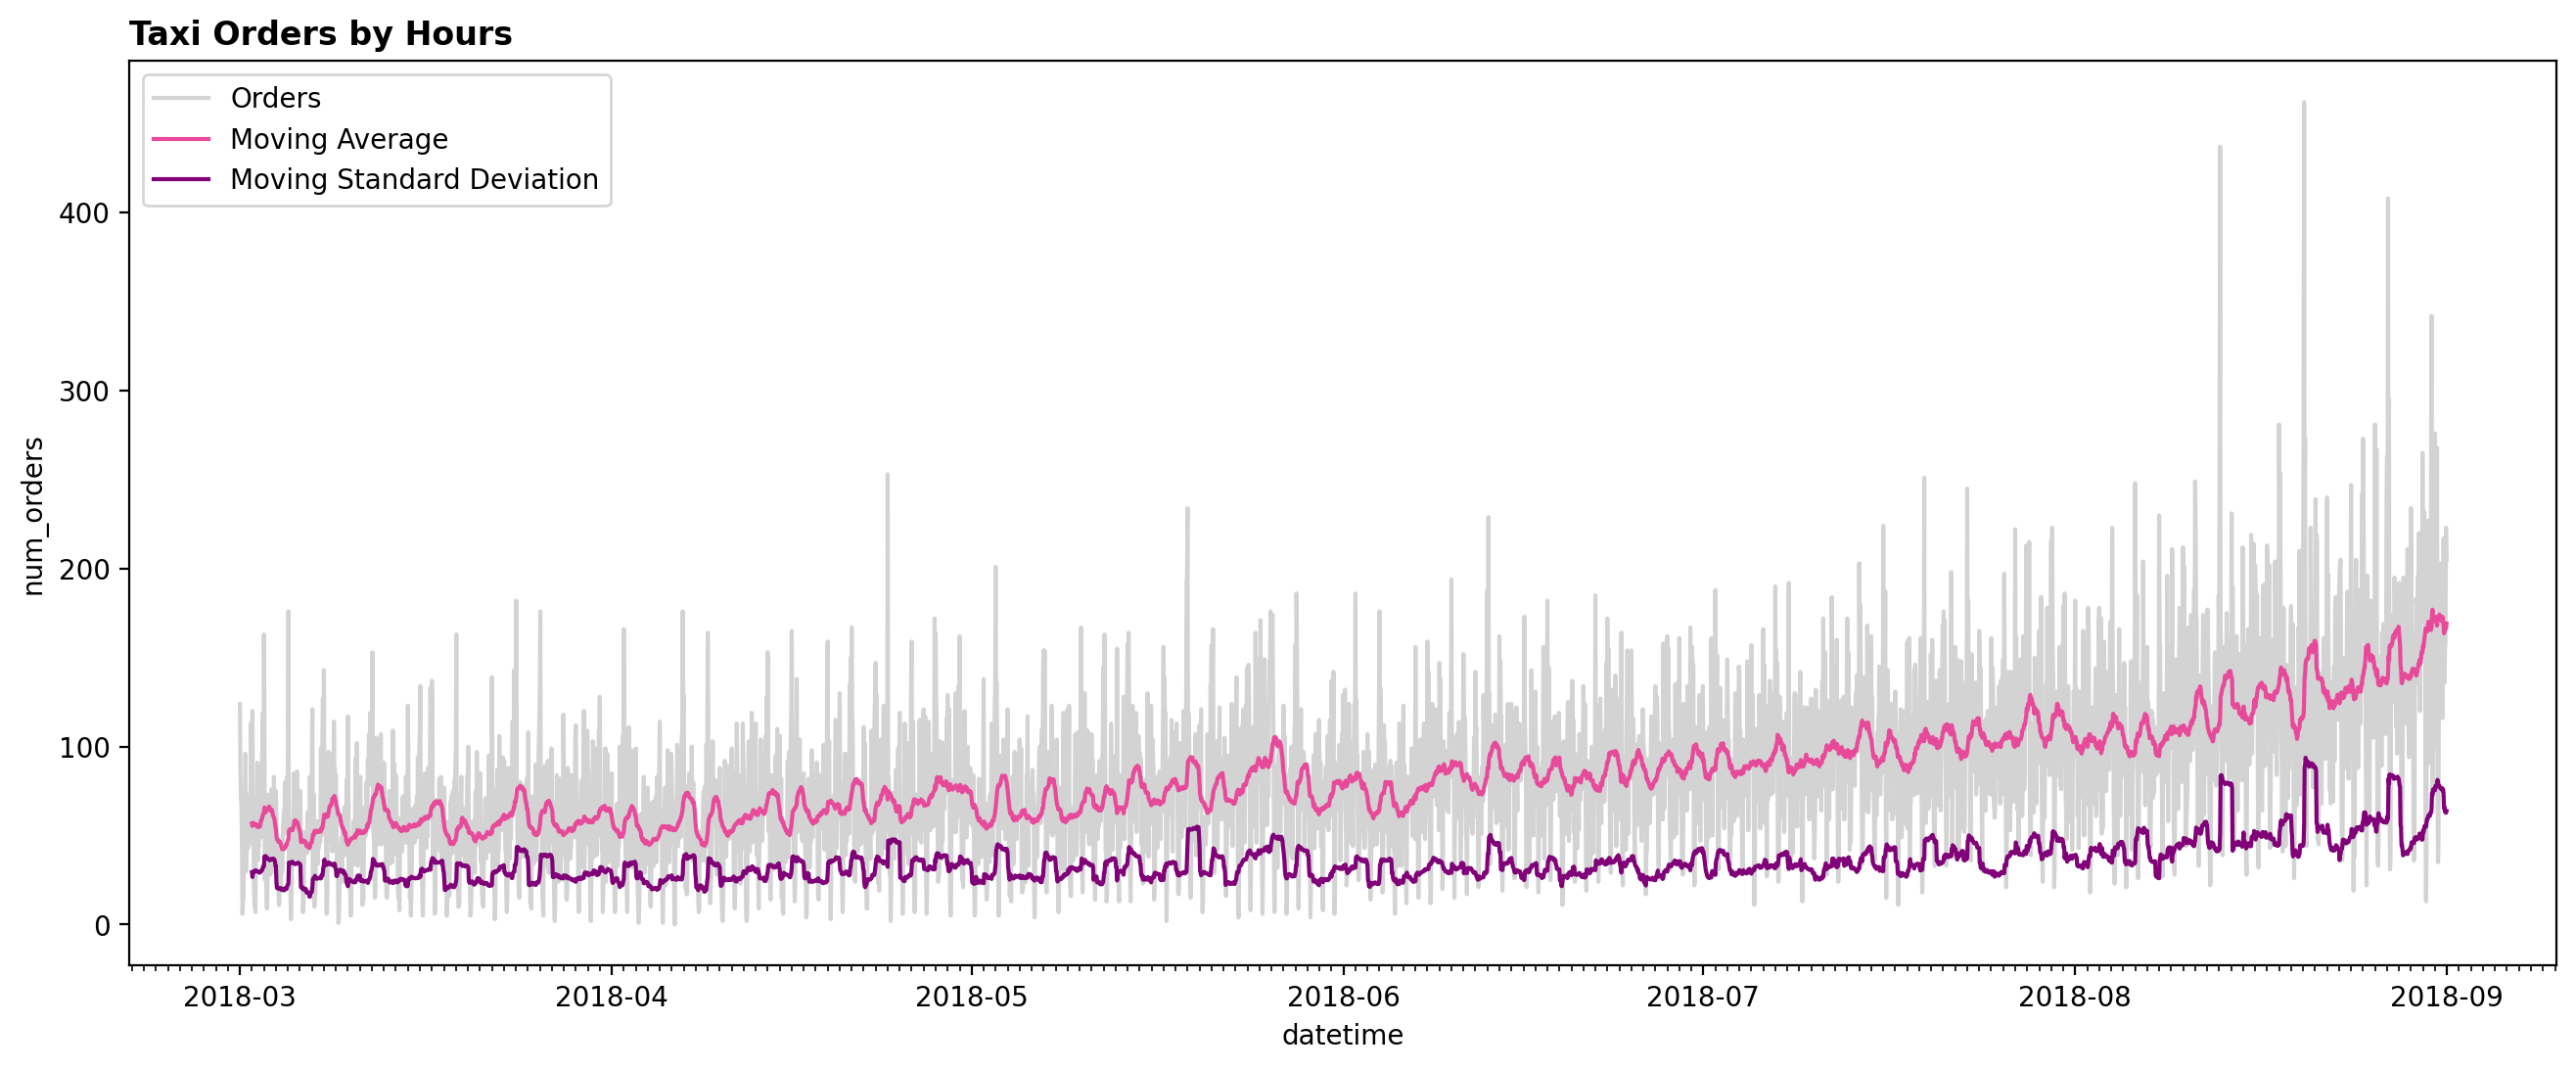

In [6]:
# Create a plot Taxi Orders by Hours
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Taxi Orders by Hours',
             loc='left',
             fontweight='semibold')

sns.lineplot(data=data, x=data.index,
             y='num_orders',
             ax=ax, color='lightgrey',
             label='Orders')

sns.lineplot(data=data, x=data.index,
             y=data['num_orders'].shift().rolling(24).mean(),
             ax=ax, color='#e84a9b',
             label='Moving Average')

sns.lineplot(data=data, x=data.index,
             y=data['num_orders'].shift().rolling(24).std(),
             ax=ax, color='#810178',
             label='Moving Standard Deviation')
ax.xaxis.set_minor_locator(dates.DayLocator(interval=1))
plt.legend()
plt.show()

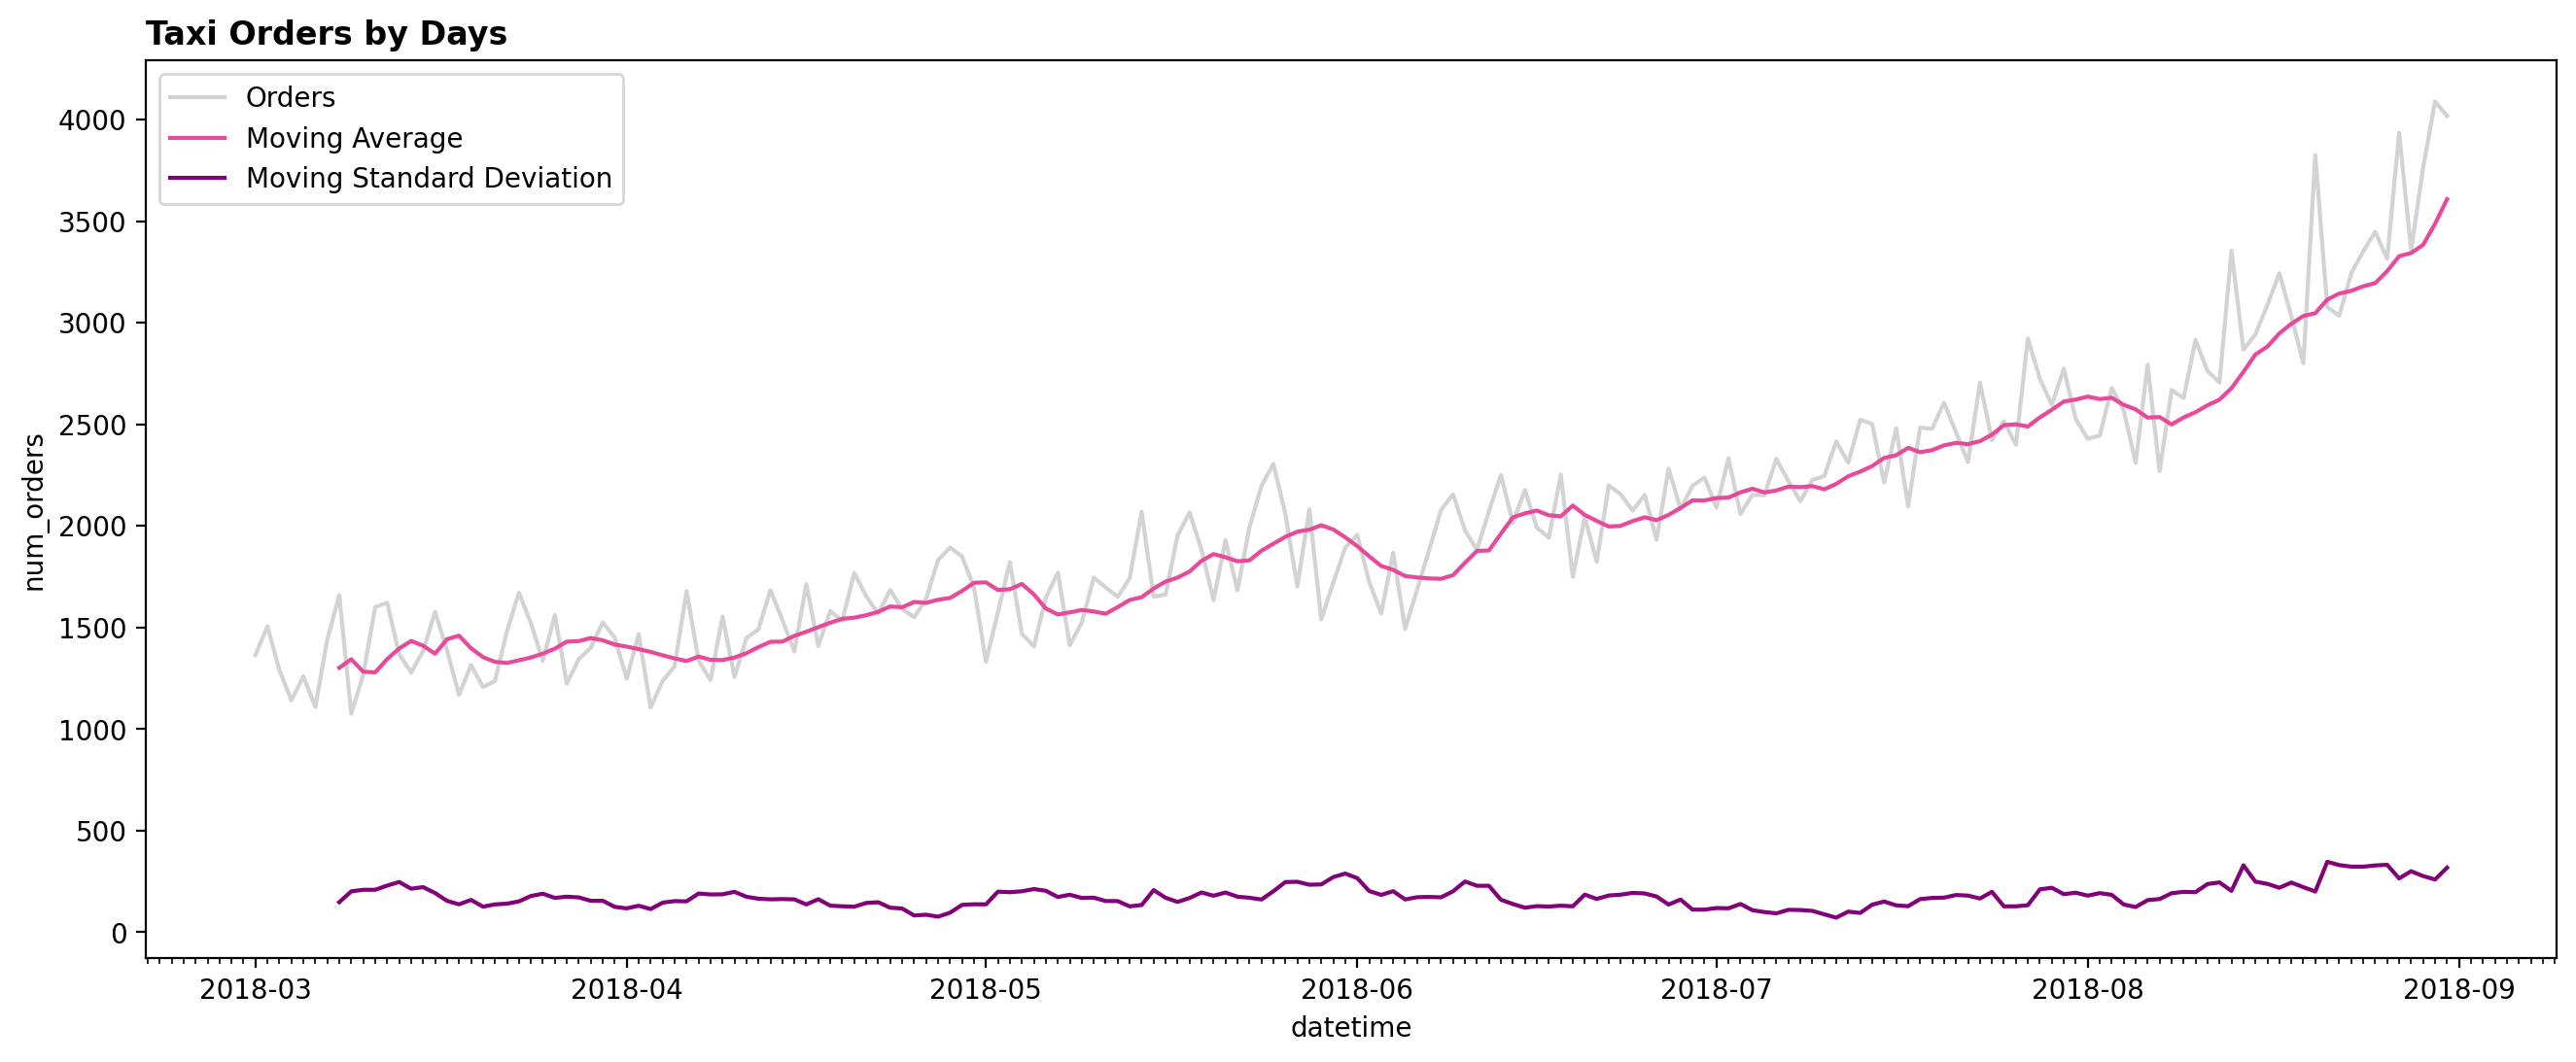

In [7]:
# Create a plot Taxi Orders by Days
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Taxi Orders by Days',
             loc='left',
             fontweight='semibold')

sns.lineplot(data=data_days, x=data_days.index,
             y='num_orders',
             ax=ax, color='lightgrey',
             label='Orders')

sns.lineplot(data=data_days, x=data_days.index,
             y=data_days['num_orders'].shift().rolling(7).mean(),
             ax=ax, color='#e84a9b',
             label='Moving Average')

sns.lineplot(data=data_days, x=data_days.index,
             y=data_days['num_orders'].shift().rolling(7).std(),
             ax=ax, color='#810178',
             label='Moving Standard Deviation')
ax.xaxis.set_minor_locator(dates.DayLocator(interval=1))
plt.legend()
plt.show()

We observe a gradual increase in the number of orders during the summer with noticeable spikes in August. We can assume that this is related to the end of the vacation season, when a large number of people return from their trips.

Moving average is changing over time, which means that the time series is non-stationary. To confirm the non-stationarity of the series, we will additionally conduct the Dickey-Fuller test.

Null and alternative hypotheses for the test are formulated as follows:

**H<sub>0</sub>:** The time series is non-stationary.

**H<sub>a</sub>:** The time series is stationary.

In [8]:
# Significance level
alpha = 0.01

# Conduct the tast
adf_test = adfuller(data)

adf_statistic = adf_test[0]
print('ADF-statistic:', adf_statistic.round(2))

p_value = adf_test[1]
print('p-value:', p_value.round(2))

# Result interpretation
if p_value < alpha:
    print(f'We reject the null hypothesis in favor of the alternative hypothesis. Time series is stationary.')
else:
    print(f'We failed to reject the null hypothesis. Time series is non-stationary.')

ADF-statistic: -3.07
p-value: 0.03
We failed to reject the null hypothesis. Time series is non-stationary.


Since the time series is non-stationary, it's necessary to account trends and seasonality. To do this, we will conduct decomposition and plot graphs for the decomposed data. For hourly decomposition, we will shorten the time interval to one week, and for daily decomposition, we will shorten it to four weeks.

In [9]:
# Data decomposition
decomposed = seasonal_decompose(data)
decomposed_hours = seasonal_decompose(data['2018-06-11':'2018-06-17'])
decomposed_days = seasonal_decompose(data_days['2018-06-04':'2018-06-24'])

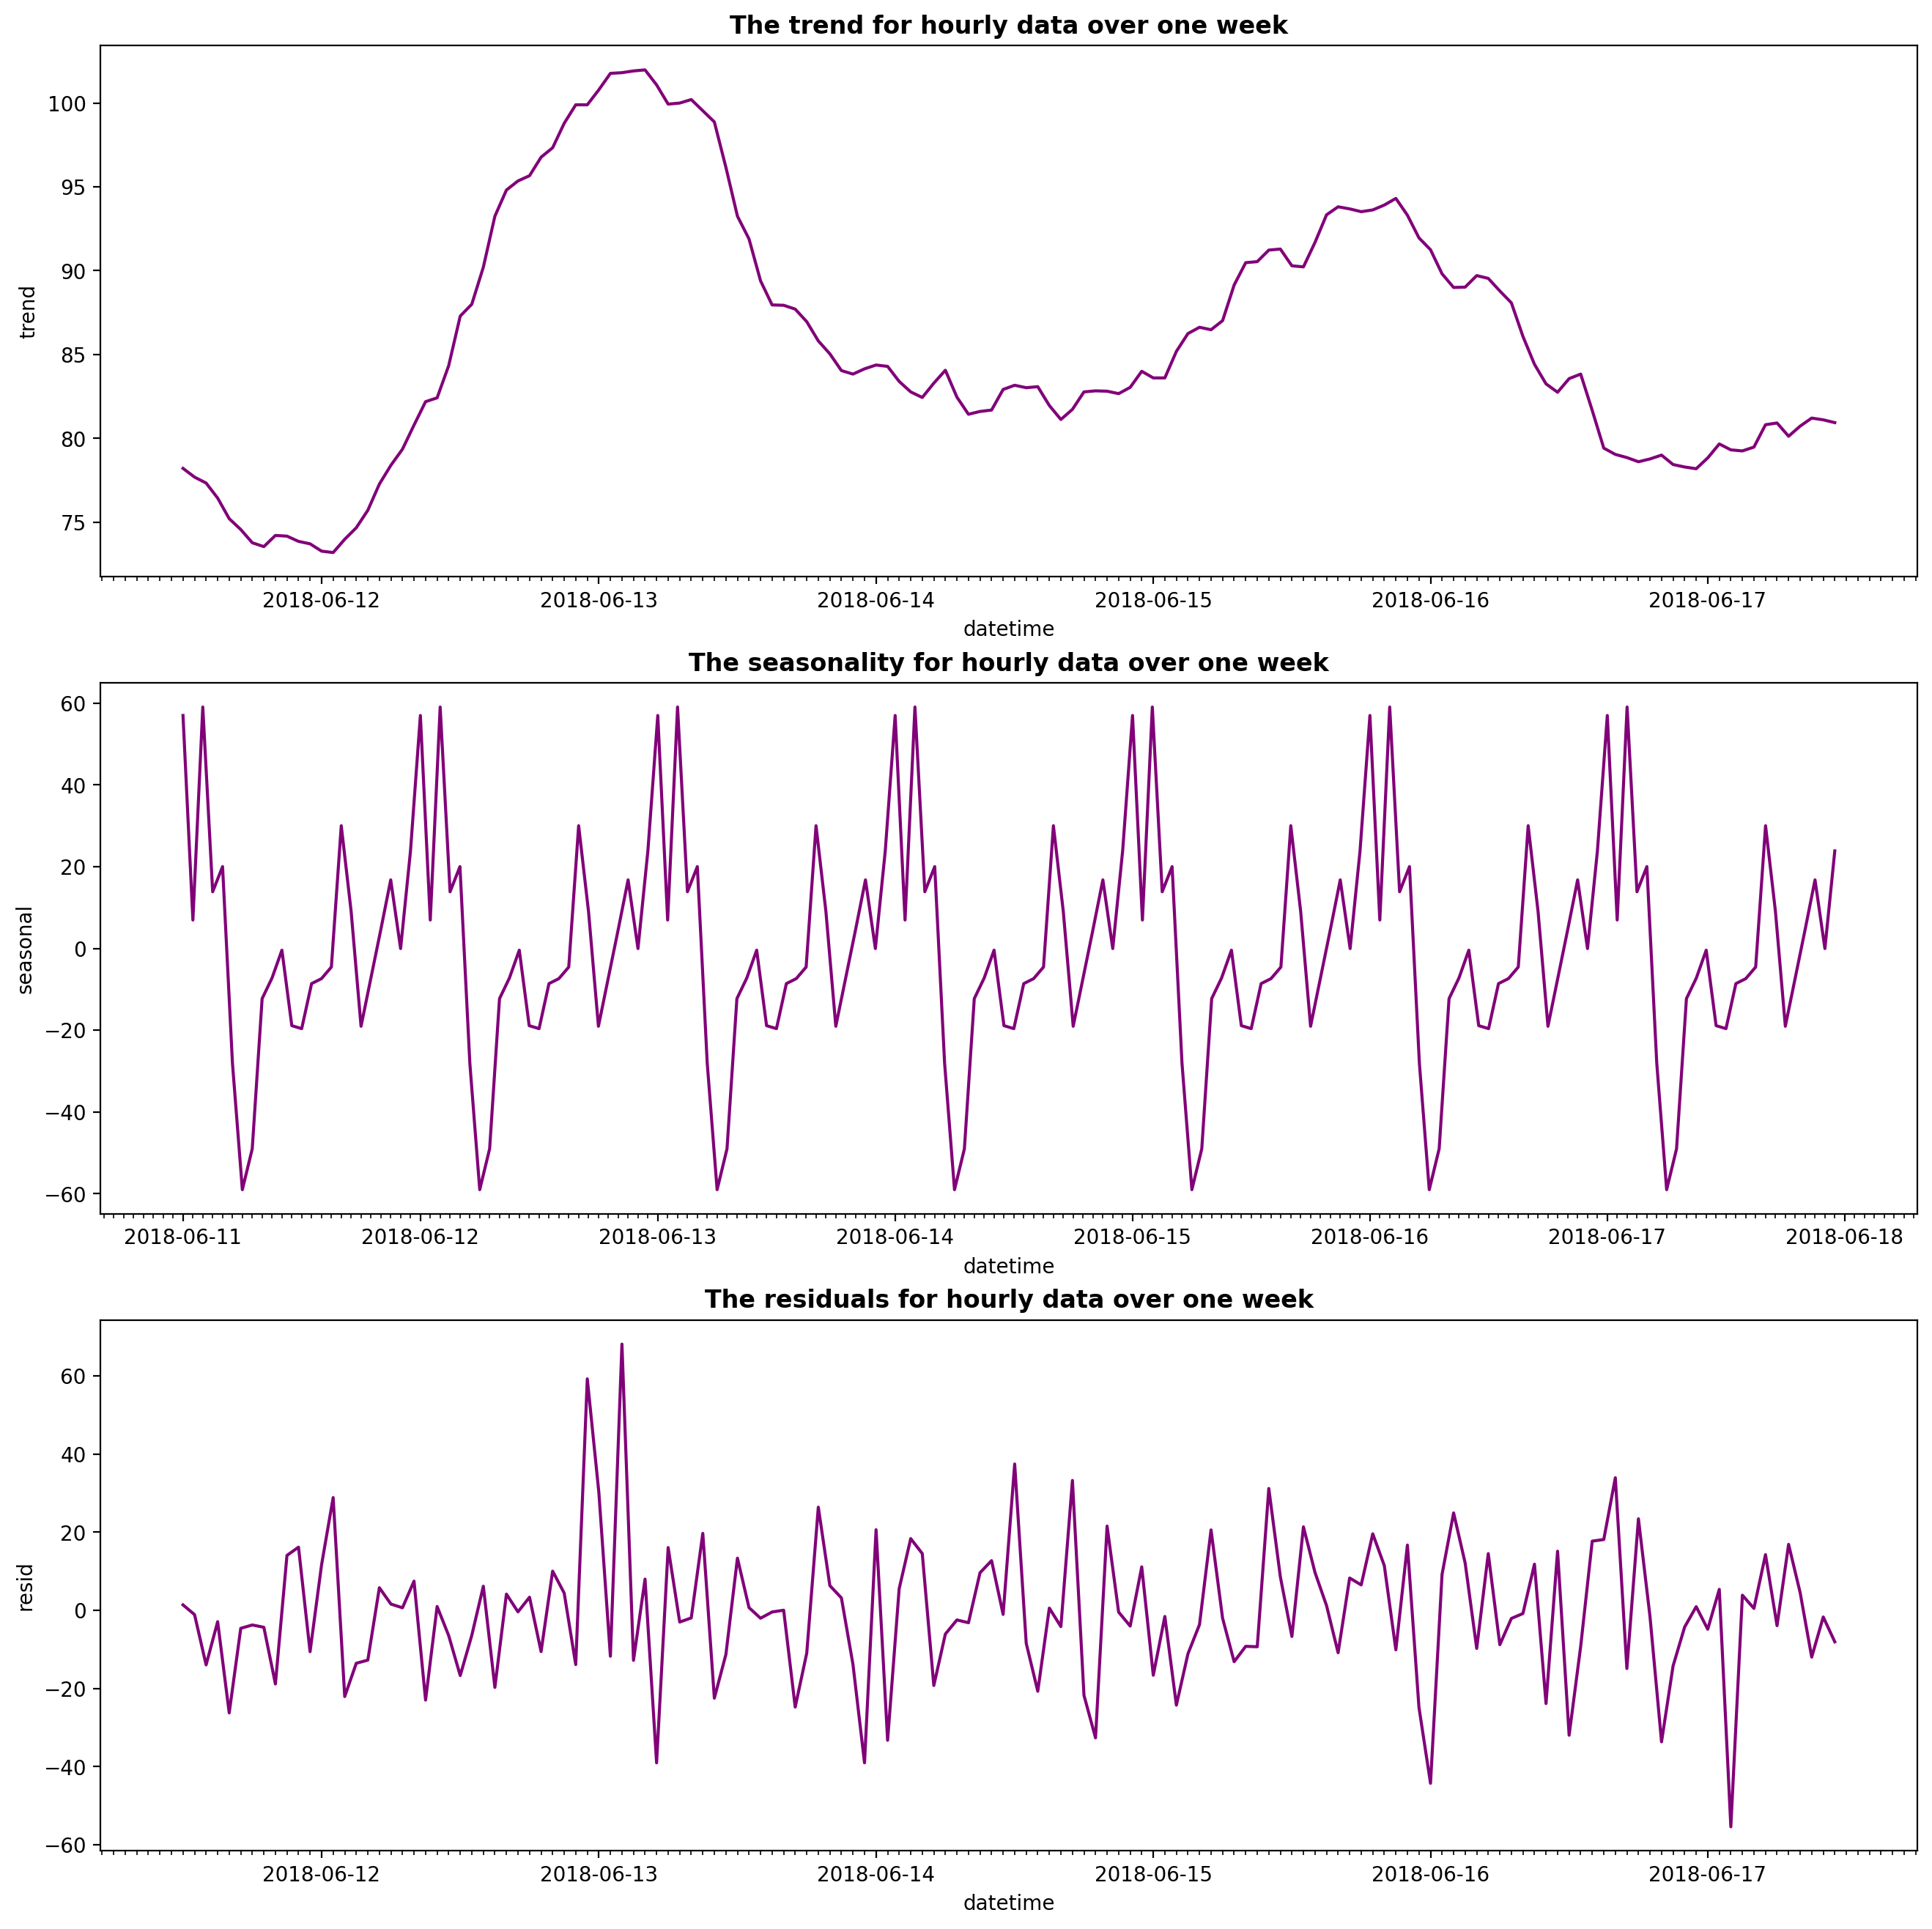

In [10]:
# Plots for trend, seasonaluty and residuals (one week)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 16))
ax[0].set_title('The trend for hourly data over one week',
                fontweight='semibold')
sns.lineplot(data=decomposed_hours, x=decomposed_hours.observed.index,
             y=decomposed_hours.trend,
             ax=ax[0], color='#810178')
ax[0].xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax[1].set_title('The seasonality for hourly data over one week',
                fontweight='semibold')
sns.lineplot(data=decomposed_hours, x=decomposed_hours.observed.index,
             y=decomposed_hours.seasonal,
             ax=ax[1], color='#810178')
ax[1].xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax[2].set_title('The residuals for hourly data over one week',
                fontweight='semibold')
sns.lineplot(data=decomposed_hours, x=decomposed_hours.observed.index,
             y=decomposed_hours.resid,
             ax=ax[2], color='#810178')
ax[2].xaxis.set_minor_locator(dates.HourLocator(interval=1))
plt.show()

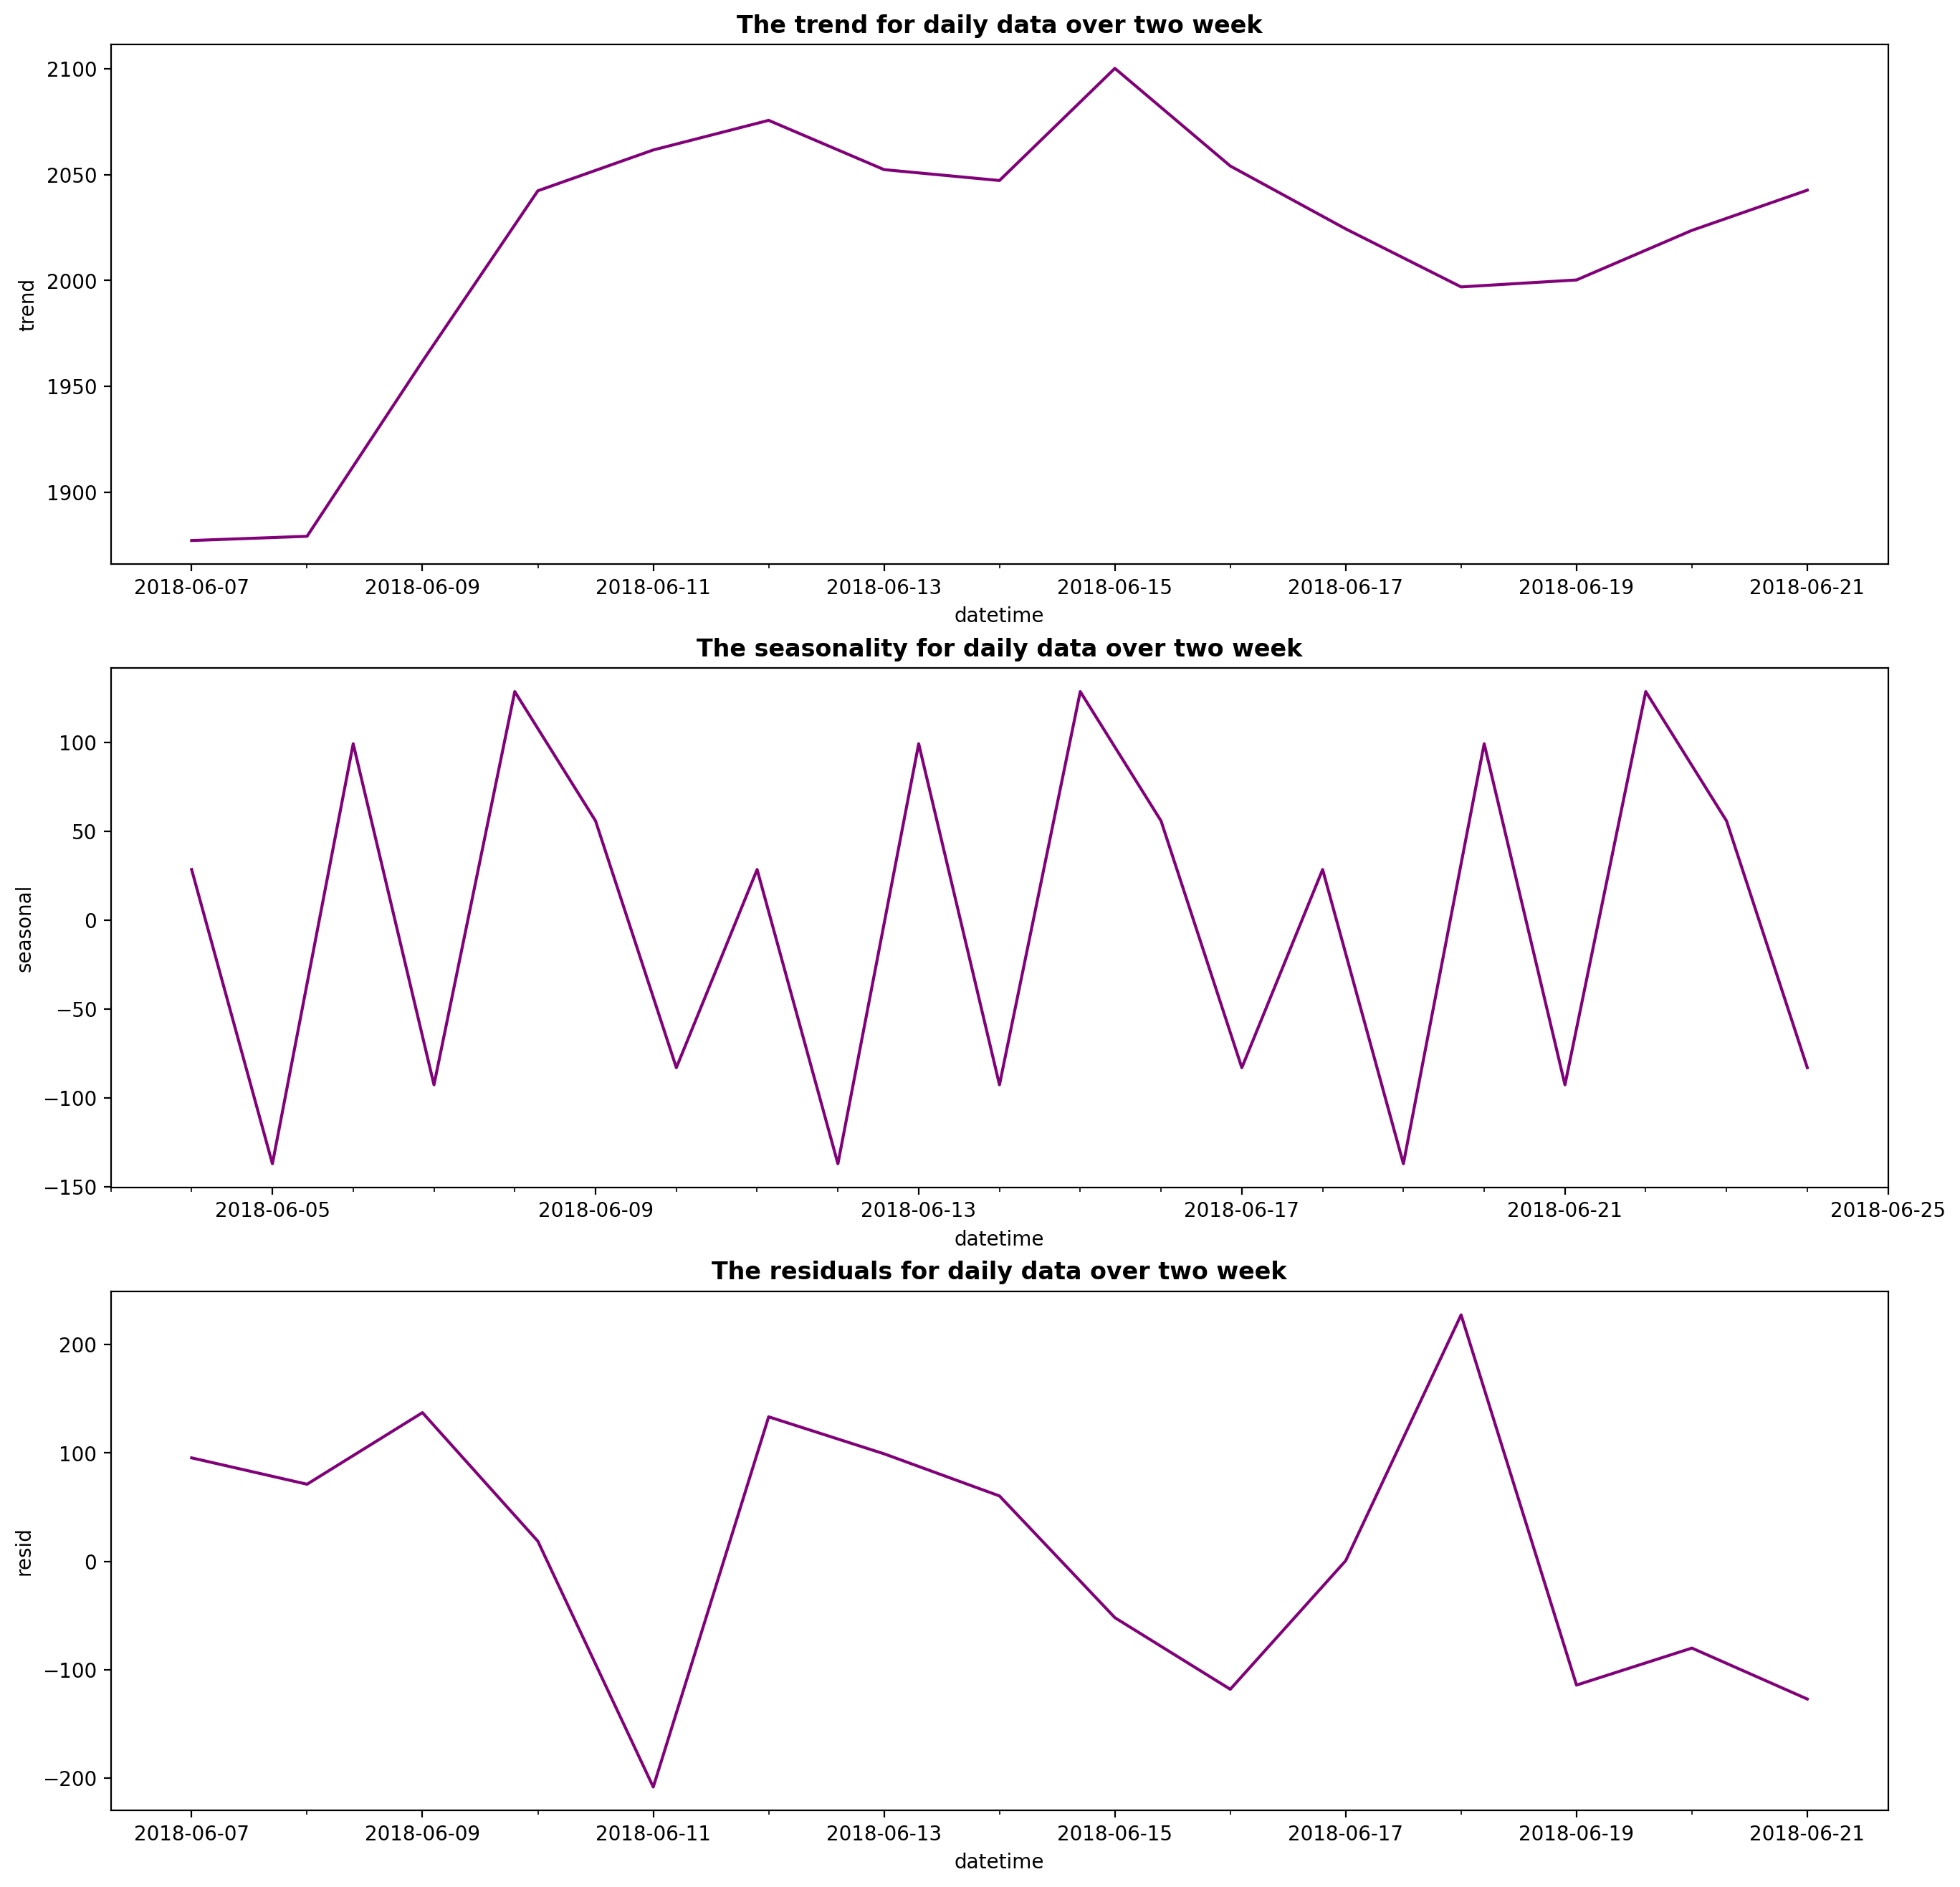

In [11]:
# Plots for trend, seasonaluty and residuals (two weeks)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 16))
ax[0].set_title('The trend for daily data over two week',
                fontweight='semibold')
sns.lineplot(data=decomposed_days, x=decomposed_days.observed.index,
             y=decomposed_days.trend,
             ax=ax[0], color='#810178')
ax[0].xaxis.set_minor_locator(dates.DayLocator(interval=1))
ax[1].set_title('The seasonality for daily data over two week',
                fontweight='semibold')
sns.lineplot(data=decomposed_days, x=decomposed_days.observed.index,
             y=decomposed_days.seasonal,
             ax=ax[1], color='#810178')
ax[1].xaxis.set_minor_locator(dates.DayLocator(interval=1))
ax[2].set_title('The residuals for daily data over two week',
                fontweight='semibold')
sns.lineplot(data=decomposed_days, x=decomposed_days.observed.index,
             y=decomposed_days.resid,
             ax=ax[2], color='#810178')
ax[2].xaxis.set_minor_locator(dates.DayLocator(interval=1))
plt.show()

We observe recurring patterns both hourly and daily.

The period of highest activity during the day is between midnight and 3:00 AM. Since we're examining taxi orders at airports, this can be explained by the fact that during the day, some people prefer to use public transport, while during the night, public transport either operates at increased intervals or does not operate at all, leading to increased demand for taxi.

The periods of highest activity throughout the week are Monday, Wednesday, and the night from Friday to Saturday.

Let's check whether the residuals follow the normal distribution.

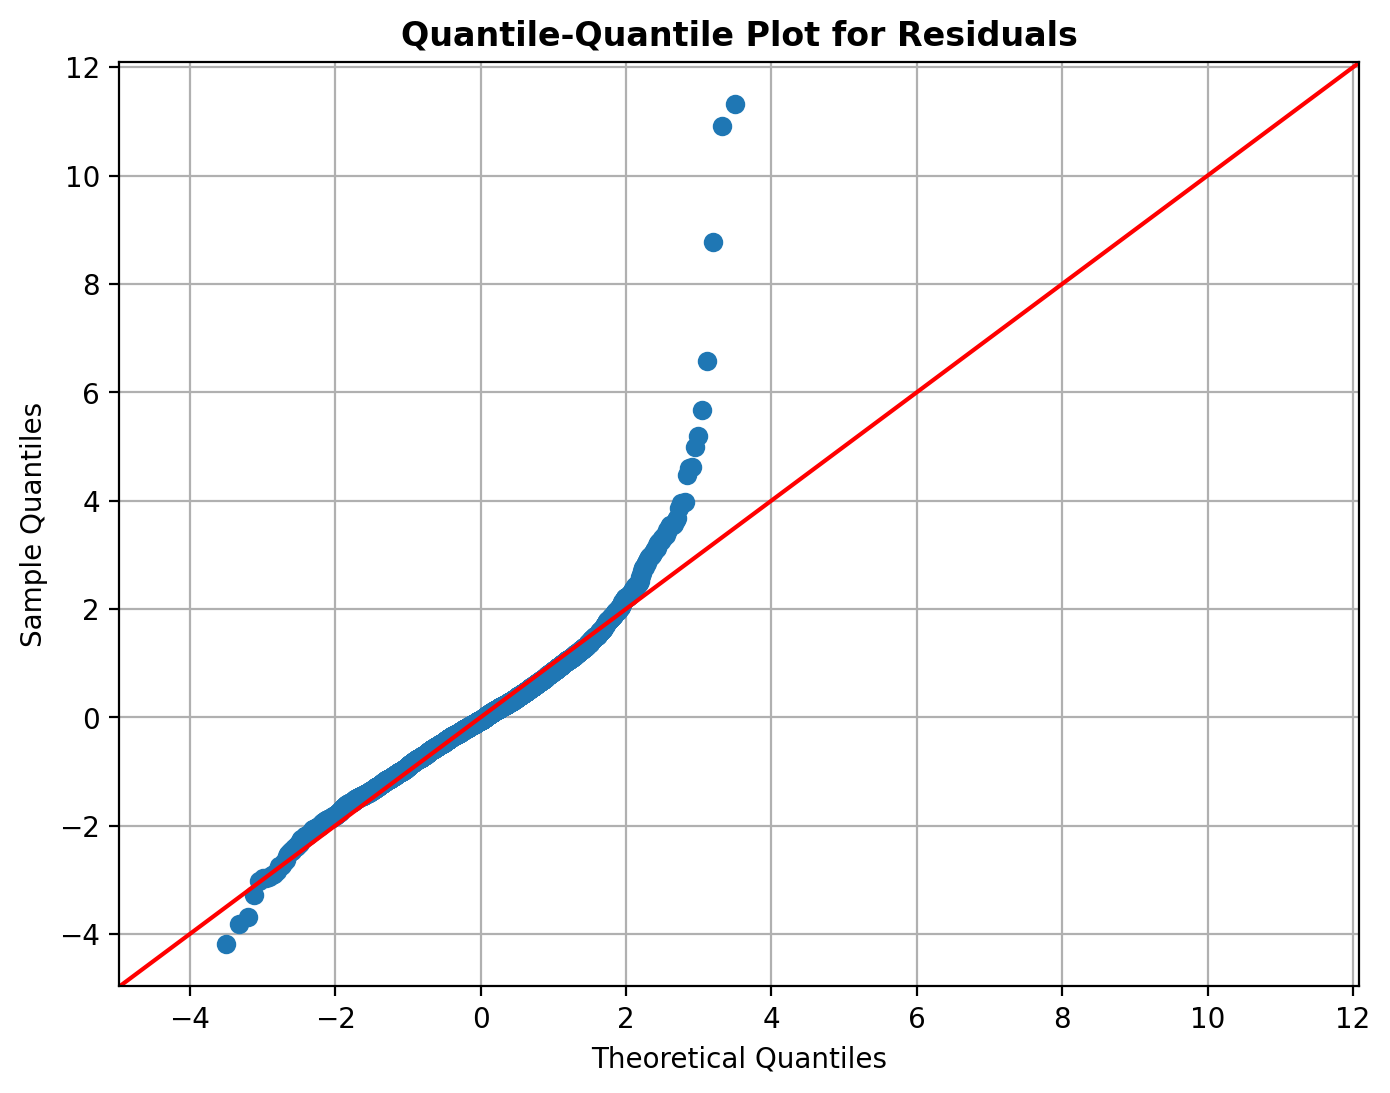

In [12]:
# QQ-plot for residuals
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.set_title('Quantile-Quantile Plot for Residuals',
             fontweight='semibold')
ax.grid()
sm.qqplot(decomposed.resid.dropna(), line='45', fit=True, ax=ax)
plt.show()

The residuals are generally normally distributed, with a small number of outliers, which we also observed in the hourly graph (peaks in August).

Let's create new features. Since we observed a pattern by days, we'll base our features on the number of orders at the same time on different days of the week. We'll also add an hour feature, as we observed an increase in the number of orders at specific hours.

In [13]:
# Create new features
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['rolling_mean'] = data['num_orders'].shift().rolling(3).mean()
data['1_day_before'] = data['num_orders'].shift(24)
data['2_days_before'] = data['num_orders'].shift(24*2)
data['3_days_before'] = data['num_orders'].shift(24*3)
data['4_days_before'] = data['num_orders'].shift(24*4)
data['5_days_before'] = data['num_orders'].shift(24*5)
data['6_days_before'] = data['num_orders'].shift(24*6)
data['7_days_before'] = data['num_orders'].shift(24*6)

### Summary

The data has been prepared and analyzed. We saw the seasonality by days of the week and months, which we will reflect in the new features. For this purpose, we have created 10 features:

* Day of the week (ordinal)
* Hour of the day (ordinal)
* Moving average of the number of orders for the previous 3 hours excluding the current hour (quantitative)
* Seven features representing the number of orders at the same time X days ago (quantitative).

Now we can proceed to model training.

## 3. Machine learning model training

We are solving a regression problem since we need to predict the exact value of a quantitative feature. At this stage, we will select the model and hyperparameters for the best prediction of the target feature, taxi orders.

After creating new features by shifting the time series, missing data has appeared. Let's remove these rows.

In [14]:
# Drop rows with NaN
data = data.dropna(axis=0)

We will split the dataset into training and testing sets. Since we're working with time series data, we must not shuffle the data.

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['num_orders'], axis=1),
    data['num_orders'],
    test_size = TEST_SIZE,
    shuffle=False)

print('Number of rows (dates) in training set:', X_train.shape[0])
print('Number of columns (features) in training set:', X_train.shape[1])
print('Indices in training set:\n', X_train.index.min(), ' | ', X_train.index.max(), '\n')

print('Number of rows (dates) in testing set:', X_test.shape[0])
print('Number of columns (features) in testing set:', X_test.shape[1])
print('Indices in testing set:\n', X_test.index.min(), ' | ', X_test.index.max())

Number of rows (dates) in training set: 3844
Number of columns (features) in training set: 10
Indices in training set:
 2018-03-07 00:00:00  |  2018-08-14 03:00:00 

Number of rows (dates) in testing set: 428
Number of columns (features) in testing set: 10
Indices in testing set:
 2018-08-14 04:00:00  |  2018-08-31 23:00:00


Let's assemble a pipeline that includes preprocessing of numerical features (scaling), feature selection, and hyperparameter tuning for 5 models:

* Linear Regression (baseline model without hyperparameters)
* Decision Tree
* Support Vector Machine Model
* Gradient Boosting using LightGBM library
* Gradient Boosting using CatBoost library

In [16]:
# Preprocessing pipe
num_columns = ['rolling_mean',
               '1_day_before',
               '2_days_before',
               '3_days_before',
               '4_days_before',
               '5_days_before',
               '6_days_before',
               '7_days_before']

data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Final pipeline
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('feature_selection', SelectKBest()),
    ('model', LinearRegression())
])

# Parameter grid for our models
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 7),
        'model__max_features': range(1, 6),
        'model__min_samples_split': range(2, 6),
        'model__min_samples_leaf': range(1, 5),
        'feature_selection__k': range(2,11)
    },
    
    {
        'model': [SVR()],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'feature_selection__k': range(2,11)
    },
    
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE, 
                                verbose=0)],
        'model__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
        'model__max_depth': range(2, 8),
        'feature_selection__k': range(2,11)
    },
    
    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE,
                                    silent=True)],
        'model__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
        'model__depth': range(2, 8),
        'feature_selection__k': range(2,11)
    }
]

The pipeline is ready. Next, we initiate a randomized search for the best model using cross-validation with the quality metric RMSE. We will need a special cross-validation method for time series because we cannot shuffle the data.

In [17]:
# Run randomized search and cross-validation for time series
search_model = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=TimeSeriesSplit(),
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter=500,
    n_jobs = -1
)
search_model.fit(X_train, y_train)

print('\nBest model and its hyperparameters:\n',
      search_model.best_estimator_['model'])
print ('RMSE (cross-validation):', abs(search_model.best_score_).round(1))


Best model and its hyperparameters:
RMSE (cross-validation): 24.0


In [18]:
# All hyperparameters
search_model.best_estimator_['model'].get_params()

{'loss_function': 'RMSE',
 'silent': True,
 'random_state': 42,
 'learning_rate': 0.05,
 'depth': 4}

Let's look at the feature importance.

In [19]:
# Selected features
data_preprocessor.fit_transform(X_test)
pd.DataFrame({'Feature': data_preprocessor.get_feature_names_out(),
              'Selected': search_model.best_estimator_['feature_selection'].get_support()})

,Feature,Selected
0,num__rolling_mean,True
1,num__1_day_before,True
2,num__2_days_before,True
3,num__3_days_before,True
4,num__4_days_before,True
5,num__5_days_before,True
6,num__6_days_before,True
7,num__7_days_before,True
8,remainder__day_of_week,True
9,remainder__hour,True


### Summary

The best model from cross-validation is the gradient boosting based on decision trees using the LightGBM library with an RMSE metric of 24. We applied feature selection in the pipeline, and all features were selected as important, indicating that we correctly interpreted the data during the analysis stage.

## 4. Machine learning model testing

Let's test our model. RMSE must be equal or less than 48.

In [20]:
# Model testing
y_pred = search_model.predict(X_test)
print('RMSE (test set):',
      abs(root_mean_squared_error(y_test, y_pred)).round(1))

RMSE (test set): 40.6


To assess the adequacy of our model, let's compare the quality of its predictions with the quality of a model that predicts a constant (DummyRegressor).

In [21]:
# Dummy Regressor
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)

dummy_rmse = root_mean_squared_error(y_test, dummy_pred).round(1)
print('RMSE (DummyRegressor):', dummy_rmse)

RMSE (DummyRegressor): 84.3


Predictions of the Dummy regressor are much worse than predictions of our model. The testing is complete and we can state that the quality of the model meets customer's requirements.

Additionally, we will analyze the residuals.

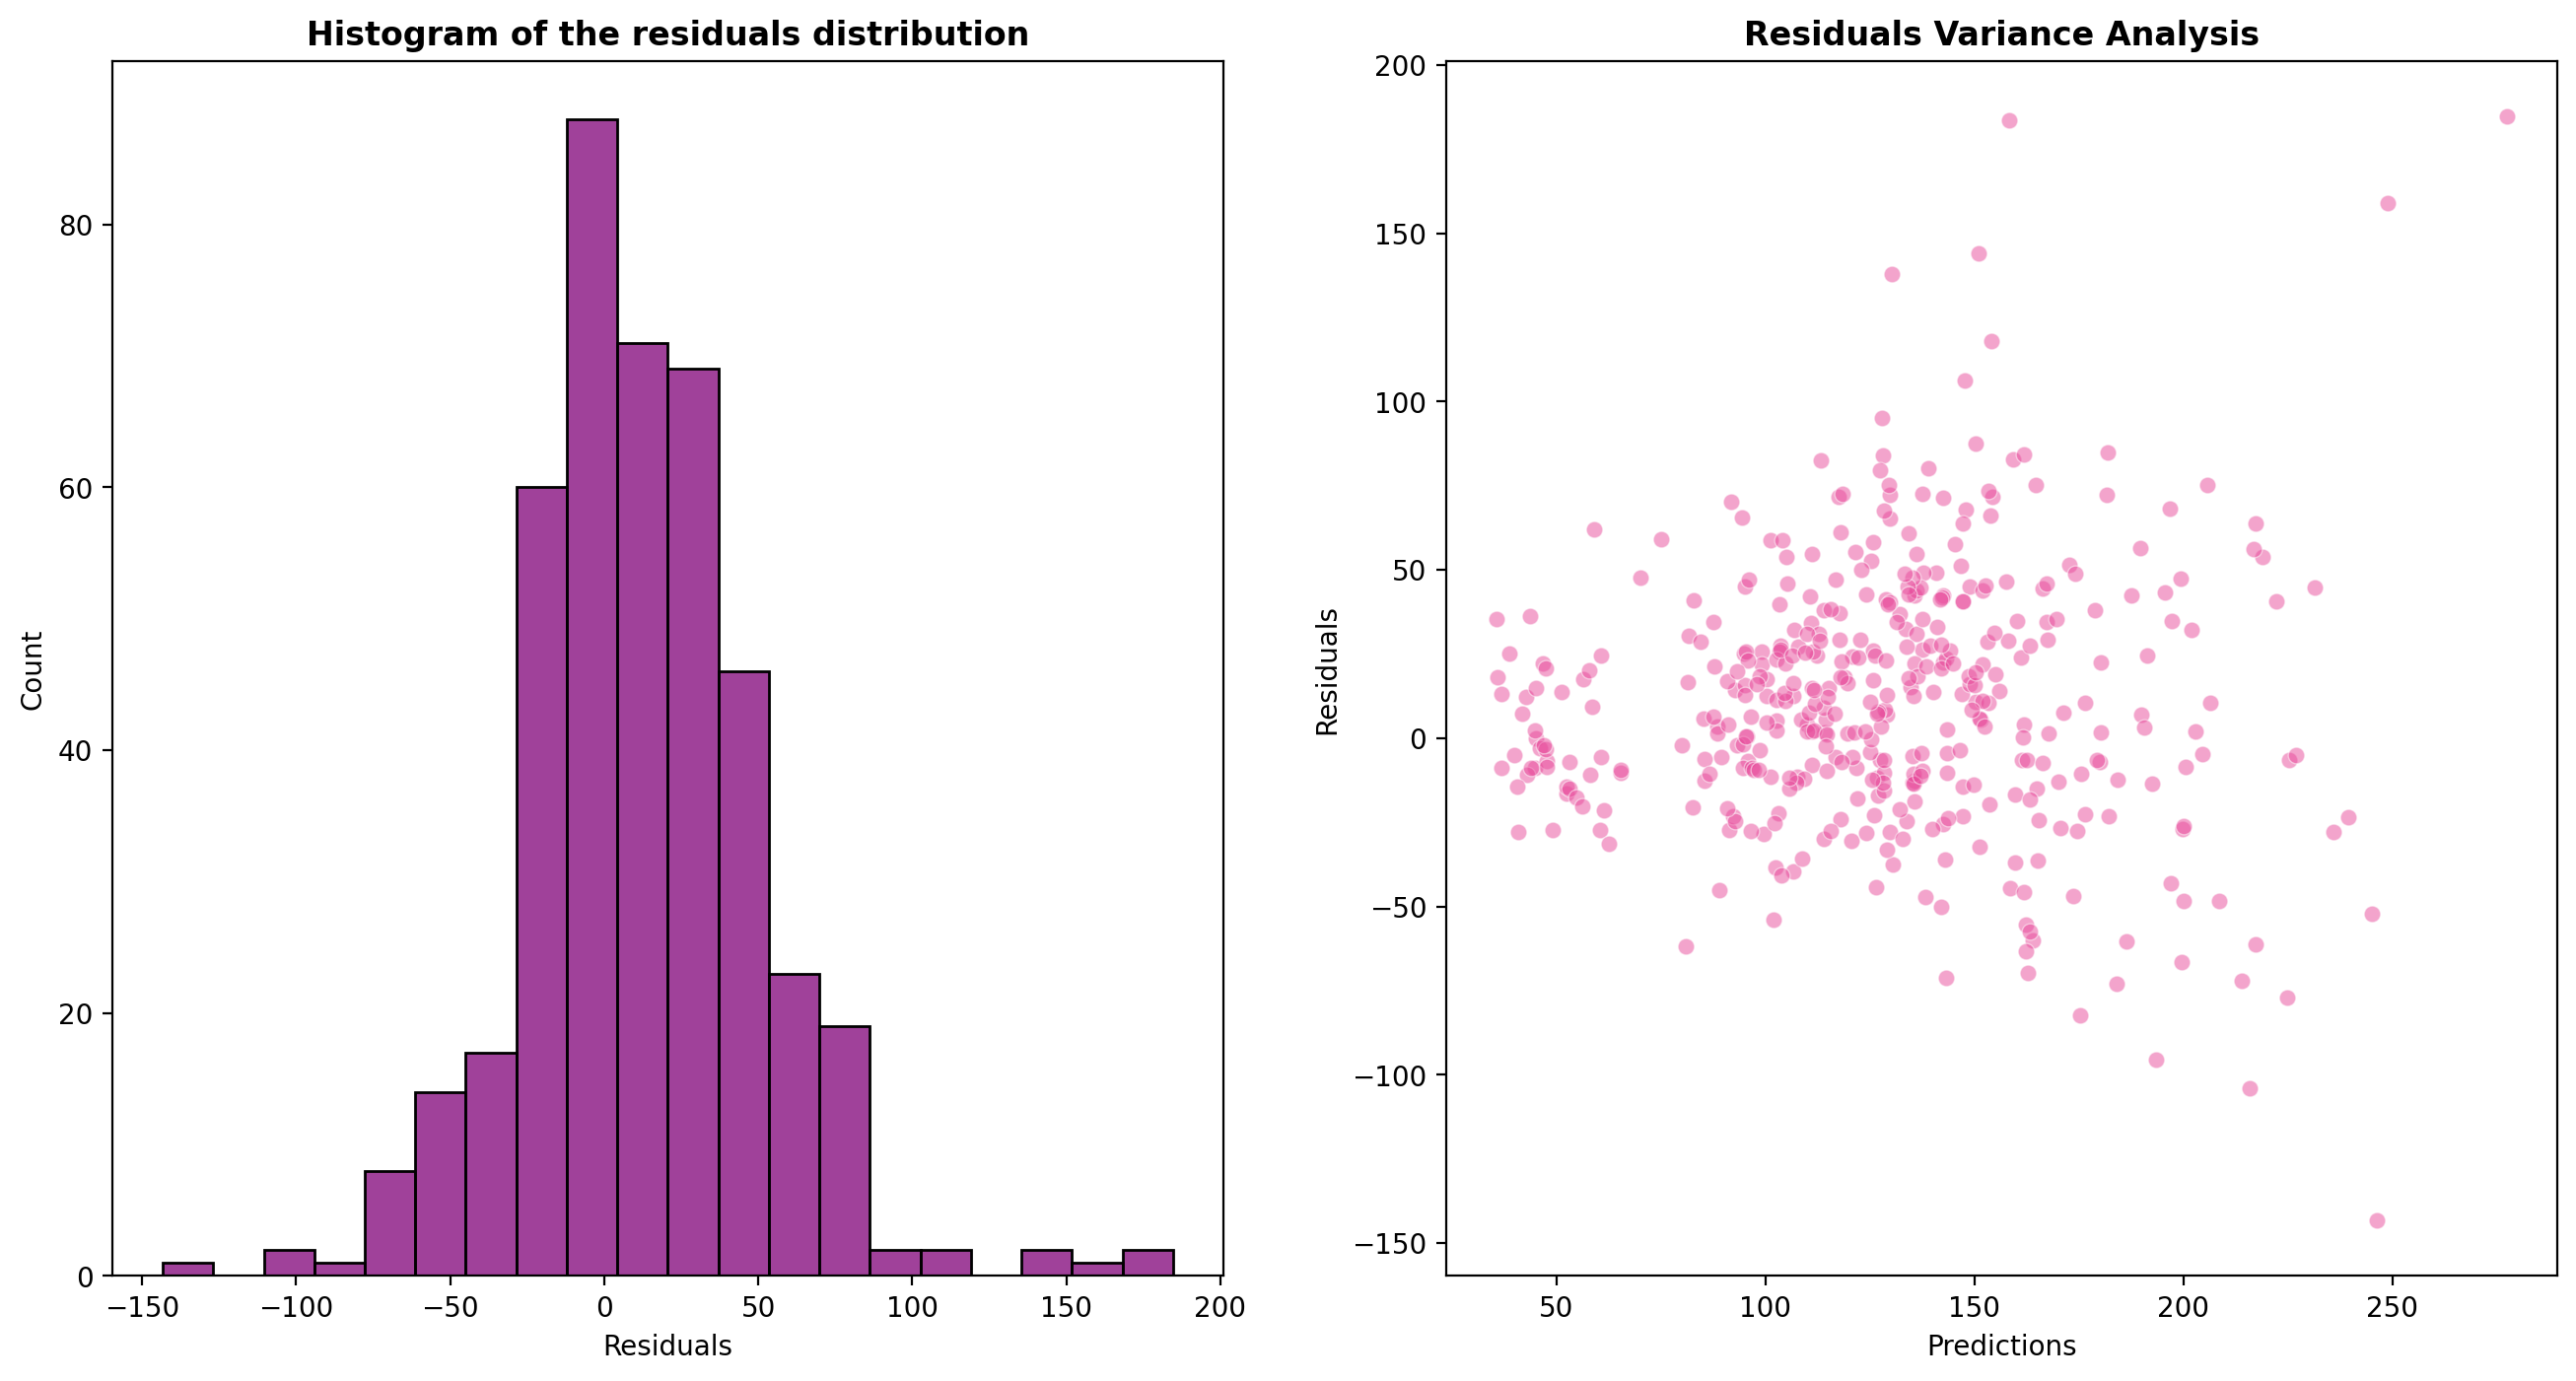

In [22]:
# Plots for residuals
residuals = y_test - y_pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.set_title('Histogram of the residuals distribution',
              fontweight='semibold')
sns.histplot(x=residuals, bins=20, ax=ax1, color='#810178')
ax1.set_xlabel('Residuals')
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=ax2, color='#e84a9b')
ax2.set_title('Residuals Variance Analysis',
              fontweight='semibold')
ax2.set_xlabel('Predictions')
ax2.set_ylabel('Residuals')
plt.show()

Let's examine the graphs to pinpoint where our model makes errors.

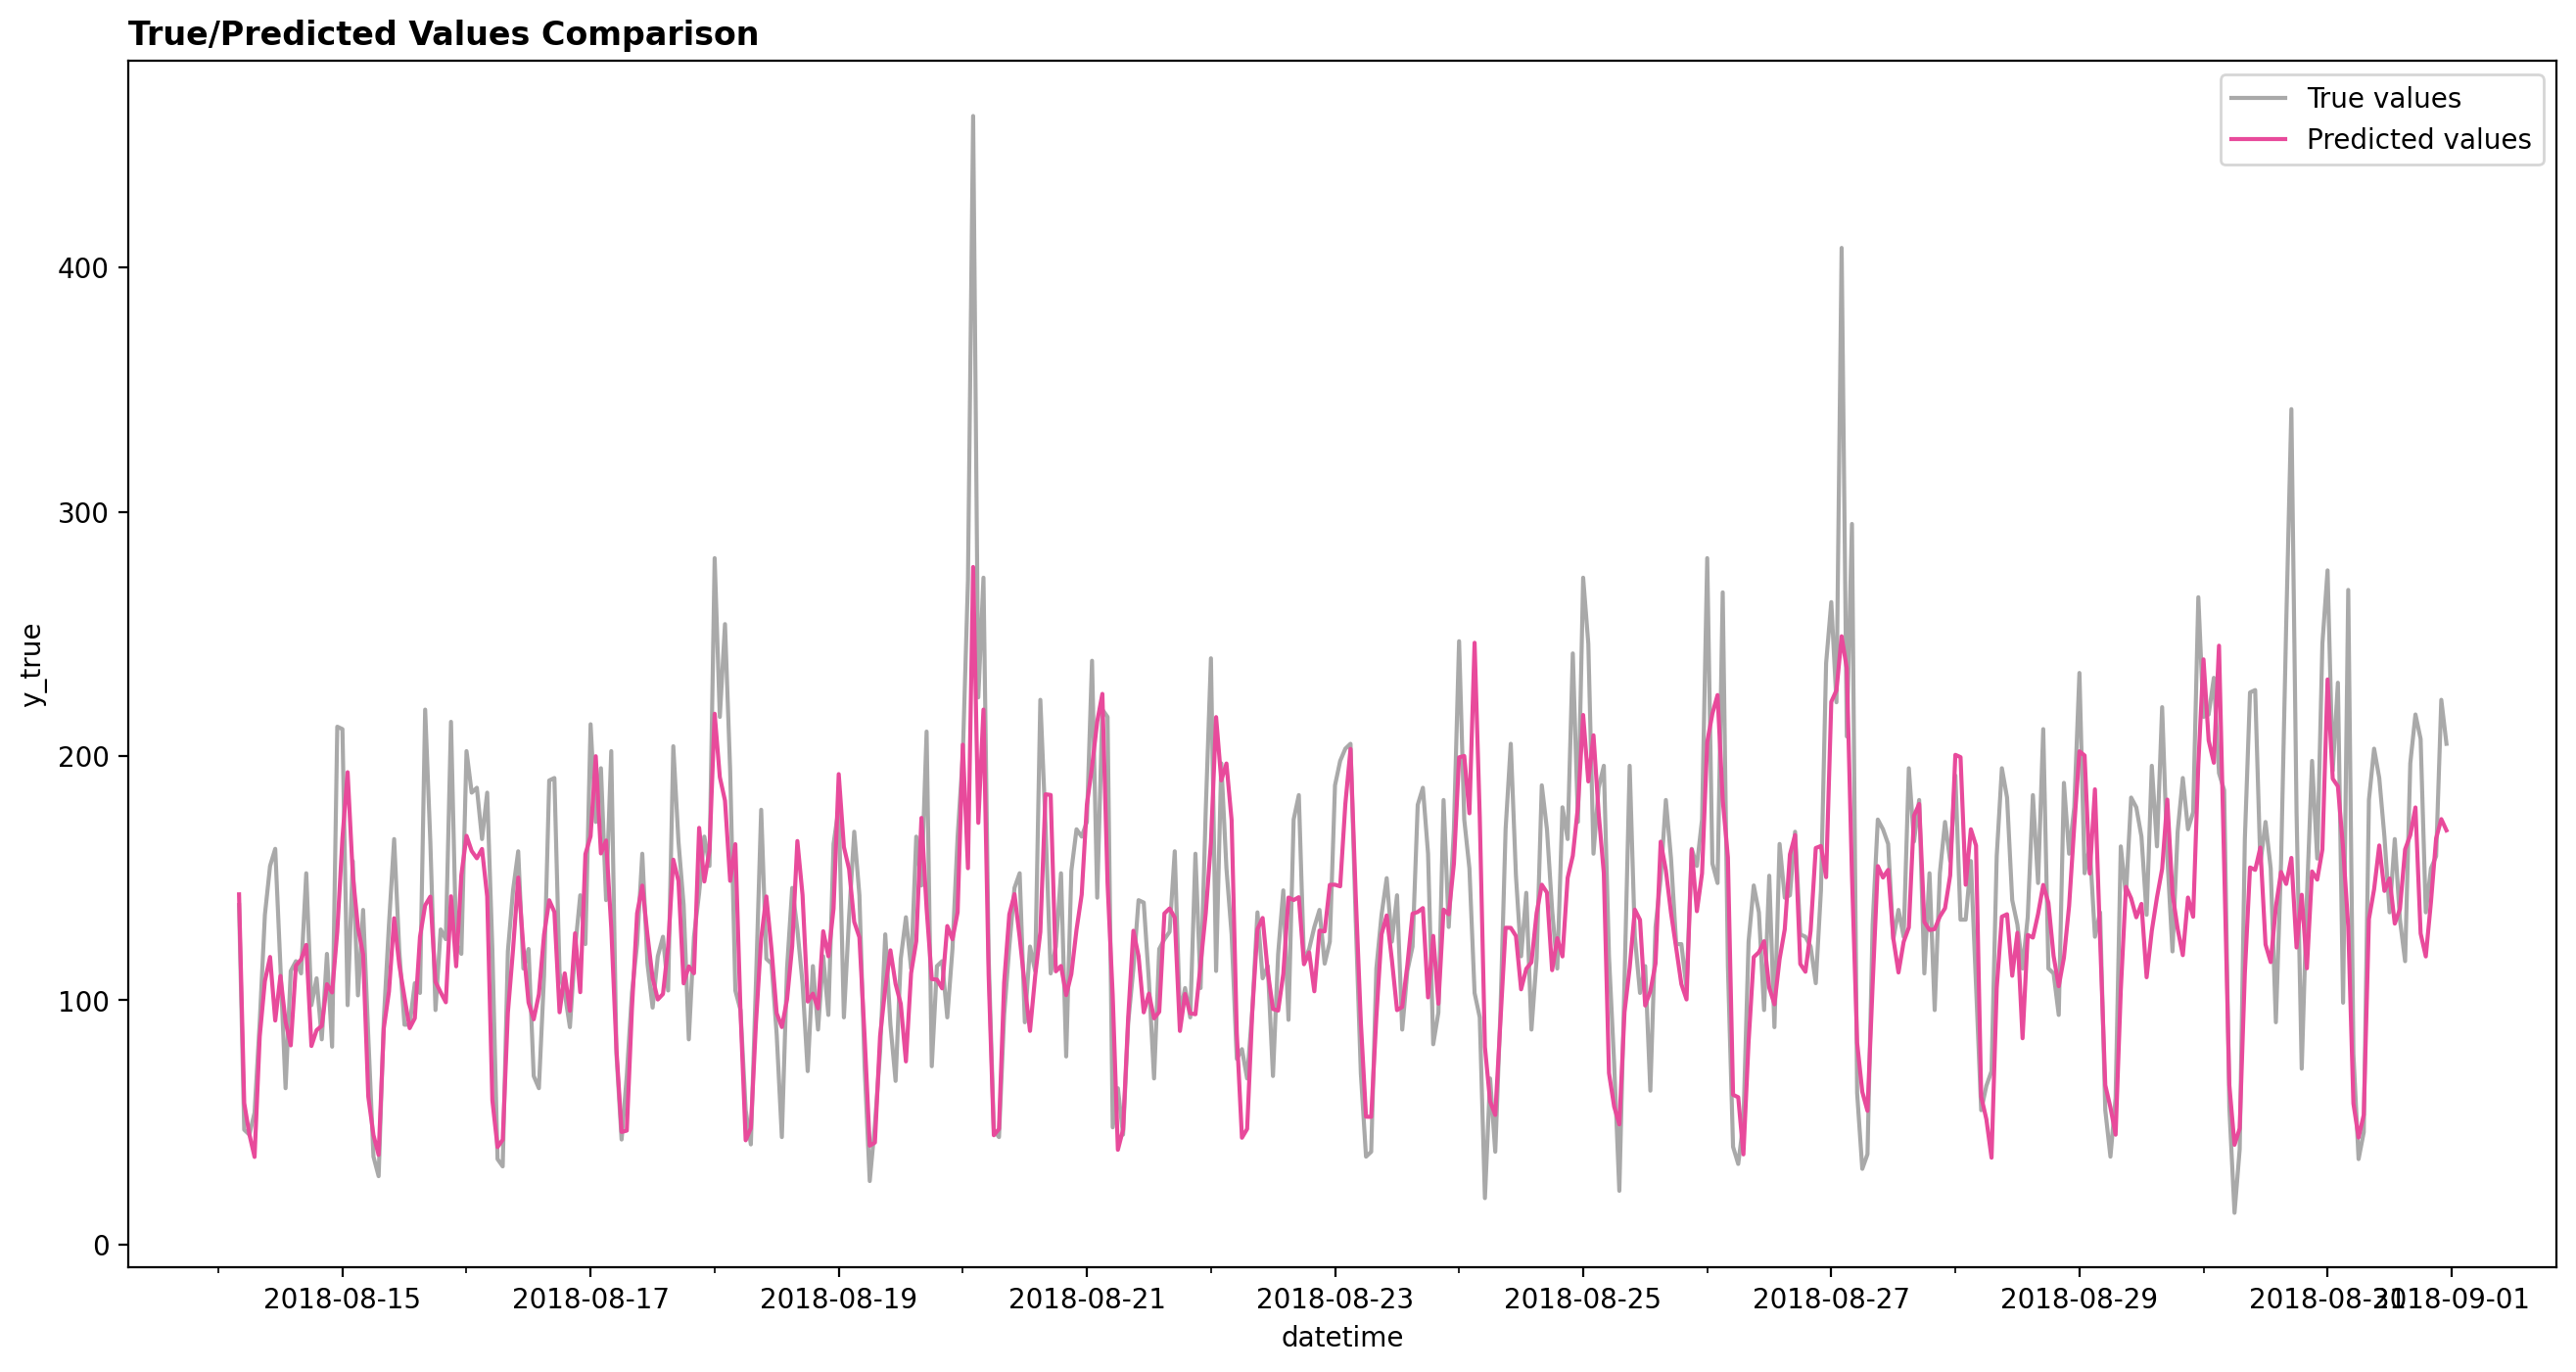

In [23]:
data_graph = pd.DataFrame({'y_true': y_test,
                           'y_pred': y_pred},
                          index = X_test.index)

fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('True/Predicted Values Comparison',
             loc='left',
             fontweight='semibold')

sns.lineplot(data=data_graph, x=data_graph.index,
             y='y_true',
             ax=ax, color='darkgrey',
             label='True values')

sns.lineplot(data=data_graph, x=data_graph.index,
             y='y_pred',
             ax=ax, color='#e84a9b',
             label='Predicted values')

ax.xaxis.set_minor_locator(dates.DayLocator(interval=1))
plt.legend()
plt.show()

### Summary

The model has shown a good result with an RMSE metric of 40.6, well below the required threshold of 48. However, residual analysis indicates that while residuals are generally normally distributed around the mean, there are outliers, suggesting that the model has not reached its maximum potential and could be improved. Analysis of residual variance confirms this: the model tends to make more errors at higher values. Comparison of actual and predicted values reveals that the model predicts daily fluctuations well but fails to predict peaks (outliers) at the end of August.

## 5. Reserach conclusion

We examined a dataset of taxi orders at airports from March 1, 2018, to August 31, 2018, aiming to build a machine learning model for predicting taxi demand in the next hour.

We created 10 new features:

* Day of the week (ordinal)
* Day of the month (ordinal)
* Rolling average of orders for the previous 3 hours excluding the current hour (quantitative)
* Seven features: number of orders at the same time 1-7 days ago (quantitative).

All were selected as important by the KBest algorithm during model training.

Predicting the number of orders is a regression task. We considered 5 models:
* Linear Regression
* Decision Tree
* Support Vector Machine
* Gradient Boosting using LightGBM
* Gradient Boosting using CatBoost

Based on cross-validation results, the model with the best RMSE value of 24.0 is `CatBoostRegressor('loss_function': 'RMSE', 'silent': True, 'random_state': 42, 'learning_rate': 0.05, 'depth': 4)`

On the test set, the model achieved an RMSE of 40.6, satisfying the customer's requirement of not exceeding 48.

Residual analysis suggests that the model's performance could be improved. We recommend gathering more data, at least for a full year, and retraining the model. Additional data would provide a more accurate assessment of seasonality and trends, potentially improving model quality.